In [384]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import re
from config import *
from clustering_utils import *

# Sklearn
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans, HDBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from kneed import KneeLocator
from scipy import stats


from scipy.cluster.hierarchy import dendrogram

import umap

# Visual
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from itertools import permutations 
from tqdm import tqdm
np.random.seed(42)

In [385]:
all_features_with_info_raw = (pd.read_parquet(FEATURES_DIR / "all_features.pq"))
all_features_with_info_raw = all_features_with_info_raw[~(all_features_with_info_raw.isna().sum(axis=1) == all_features_with_info_raw.shape[1]-2)]


y = pd.DataFrame(all_features_with_info_raw["y"], columns=["y"])


all_features_with_info = (all_features_with_info_raw
        .pipe(remove_low_variance_features)
        .pipe(remove_multicollineraity, y)
        .pipe(remove_outliers, 10.0)
)

X = (all_features_with_info.query("y==1")
 .drop(["participant_id", "y"], axis=1)
 .dropna()
)

X_stdz = pd.DataFrame(StandardScaler().fit_transform(X.values), columns=X.columns)

metric = 'euclidean'
linkage = 'ward'

/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/feature_selection/_variance_threshold.py:114: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
2025-05-09 16:50:29,168 - INFO - clustering_utils.remove_low_variance_features:50 - Kept 465 features out of 520
2025-05-09 16:50:29,256 - INFO - clustering_utils.remove_multicollineraity:108 - Removed 164 highly correlated features: {'SHAPES_duration_mean_fix', 'REACTION_total_acceleration_magnitude_std', 'EVIL_BASTARD_avg_pupil_size_median_fix', 'SHAPES_amplitude_mean_sacc', 'SMOOTH_PURSUITS_avg_pupil_size_min_fix', 'REACTION_peak_velocity_mean_sacc', 'EVIL_BASTARD_fixations_per_second_min', 'KING_DEVICK_avg_pupil_size_mean_fix', 'KING_DEVICK_duration_max_fix', 'SHAPES_fixations_per_second_max', 'FITTS_LAW_fixations_per_second_median', 'FITTS_LAW_avg_pupil_size_min_fix', 'ANTI_SACCADE_avg_pupil_size_min_fix', 'KING_DE

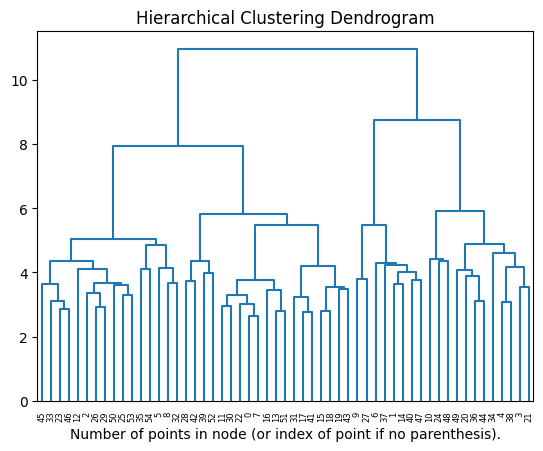

In [386]:



def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0,n_clusters=None,  linkage=linkage, metric=metric)


model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode = 'level', p=100, color_threshold=0)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [435]:
n_clusters_to_try = range(3,4)

clustering_results = {
    "n_clusters": [],
    "silhouette_scores": [],
    "davies_bouldin_score": [],
    "labels": []
}

for n_cluster in n_clusters_to_try:
    model = AgglomerativeClustering(n_clusters=n_cluster, linkage=linkage, metric=metric)
    model.fit(X)
    labels = model.labels_
    sil_score = silhouette_score(X, labels)
    db_score = davies_bouldin_score(X, labels)
    clustering_results["silhouette_scores"].append(sil_score)
    clustering_results["davies_bouldin_score"].append(db_score)
    clustering_results["n_clusters"].append(n_cluster)
    clustering_results["labels"].append(model.labels_)

clustering_results = pd.DataFrame(clustering_results)

In [436]:
clustering_results

,n_clusters,silhouette_scores,davies_bouldin_score,labels
0,3,0.107278,2.390721,"[0, 2, 0, 1, 1, 0, 2, 0, 0, 2, 1, 0, 0, 0, 2, ..."


In [437]:
feature_importance_results = {
    'best_params': [],
    'n_clusters': [],
    'feature_importances': [],
    'silhouette_scores': [],
    'labels': []
}

for i, row in tqdm(clustering_results.iterrows(), total=clustering_results.shape[0]):
    n_cluster = row["n_clusters"]
    silhoette_scores = row["silhouette_scores"]
    y = row["labels"]
    print(y)
    # Initialize results

    feature_importances = pd.DataFrame(
        np.zeros(X.shape[1]), 
        columns=["Importance"], 
        index=X.columns)

    # Hyperparameters for GridSearch
    parameters = {
        'max_depth': [None, 3, 5, 7, 9, 11],
        'n_estimators': [20, 30, 40, 50, 70, 100],
        'max_features': ['sqrt', 'log2']
    }


    # Find best clf
    grid_search = GridSearchCV(
        RandomForestClassifier(n_jobs=-1, random_state=42), 
        parameters, 
        cv=10,
        verbose=5, 
        n_jobs=-1)

    grid_search.fit(X, y)

    best_model = grid_search.best_estimator_
    importances = best_model.feature_importances_
    best_params = grid_search.best_params_

    # update importances
    feature_importances.loc[X.columns, "Importance"] += importances
    
    feature_importance_results["best_params"].append(best_params)
    feature_importance_results["feature_importances"].append(feature_importances)
    feature_importance_results['n_clusters'].append(n_cluster)
    feature_importance_results["silhouette_scores"].append(silhoette_scores)
    feature_importance_results["labels"].append(y)



  0%|          | 0/1 [00:00<?, ?it/s]

[0 2 0 1 1 0 2 0 0 2 1 0 0 0 2 0 0 0 0 0 1 1 0 0 1 0 0 2 0 0 0 0 0 0 1 0 1
 2 1 0 2 0 0 0 1 0 0 2 1 1 0 0 0 0 0]
Fitting 10 folds for each of 72 candidates, totalling 720 fits


/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


[CV 3/10] END max_depth=None, max_features=sqrt, n_estimators=20;, score=1.000 total time=   0.1s
[CV 4/10] END max_depth=None, max_features=sqrt, n_estimators=20;, score=1.000 total time=   0.1s
[CV 5/10] END max_depth=None, max_features=sqrt, n_estimators=20;, score=0.833 total time=   0.1s
[CV 1/10] END max_depth=None, max_features=sqrt, n_estimators=20;, score=1.000 total time=   0.1s
[CV 6/10] END max_depth=None, max_features=sqrt, n_estimators=20;, score=0.800 total time=   0.1s
[CV 2/10] END max_depth=None, max_features=sqrt, n_estimators=20;, score=0.833 total time=   0.1s
[CV 7/10] END max_depth=None, max_features=sqrt, n_estimators=20;, score=0.800 total time=   0.1s
[CV 9/10] END max_depth=None, max_features=sqrt, n_estimators=20;, score=0.600 total time=   0.1s
[CV 8/10] END max_depth=None, max_features=sqrt, n_estimators=20;, score=0.600 total time=   0.1s
[CV 10/10] END max_depth=None, max_features=sqrt, n_estimators=20;, score=0.800 total time=   0.1s
[CV 1/10] END max_d

100%|██████████| 1/1 [00:05<00:00,  5.99s/it]

[CV 8/10] END max_depth=11, max_features=log2, n_estimators=70;, score=0.600 total time=   0.1s
[CV 10/10] END max_depth=11, max_features=log2, n_estimators=70;, score=1.000 total time=   0.1s
[CV 2/10] END max_depth=11, max_features=log2, n_estimators=100;, score=0.833 total time=   0.1s
[CV 4/10] END max_depth=11, max_features=log2, n_estimators=100;, score=1.000 total time=   0.1s
[CV 6/10] END max_depth=11, max_features=log2, n_estimators=100;, score=0.600 total time=   0.1s
[CV 8/10] END max_depth=11, max_features=log2, n_estimators=100;, score=0.800 total time=   0.1s
[CV 10/10] END max_depth=11, max_features=log2, n_estimators=100;, score=1.000 total time=   0.1s


2025-05-09 16:59:22,471 - INFO - 3390461092.<module>:32 - Knee detected at feature rank 6
2025-05-09 16:59:22,473 - INFO - 3390461092.<module>:40 - Automatically selected 25 features


<Axes: >

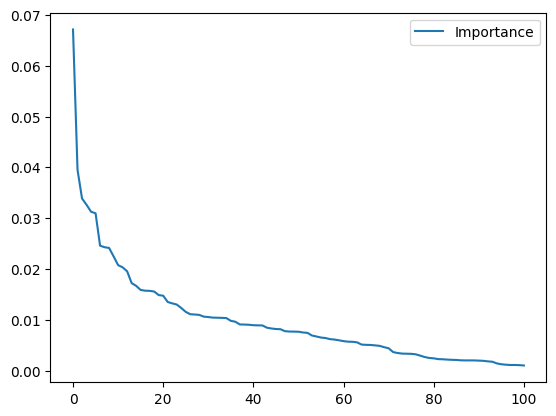

In [438]:
selected_features_results = {
    'best_params': [],
    'selected_features': [],
    "n_clusters": [],
    "silhouette_scores": [],
    "labels": []
    
}

for i, feature_importances in enumerate(feature_importance_results["feature_importances"]):
    
    sorted_feature_importance = (feature_importances
    .sort_values("Importance", ascending=False)
    .reset_index()
    .query("Importance > 0")
    )


    importance_values = sorted_feature_importance["Importance"].values
    feature_ranks = np.arange(len(importance_values))

    # Find knee
    knee = KneeLocator(
        feature_ranks, 
        importance_values, 
        curve='convex', 
        direction='decreasing'
    )
    knee_point = knee.knee

    if knee_point is not None:
        logging.info(f"Knee detected at feature rank {knee_point}")
    else:
        logging.warning("Knee point is not detected")
        knee_point = len(sorted_feature_importance) - 1

    # Select features above knee
    # selected_features = sorted_feature_importance.iloc[:knee_point+1]
    selected_features = sorted_feature_importance.iloc[:25]
    logging.info(f"Automatically selected {selected_features.shape[0]} features")

    selected_features_results["selected_features"].append(selected_features)
    selected_features_results["n_clusters"].append(feature_importance_results["n_clusters"][i])
    selected_features_results["silhouette_scores"].append(feature_importance_results["silhouette_scores"][i])
    selected_features_results["labels"].append(feature_importance_results["labels"][i])
    selected_features_results["best_params"].append(feature_importance_results["best_params"][i])

sorted_feature_importance.plot()

In [439]:
selected_features_results["selected_features"]

[                                         index  Importance
 0      EVIL_BASTARD_distance_to_fixpoint_x_std    0.067150
 1   SMOOTH_PURSUITS_distance_to_fixpoint_y_std    0.039530
 2               KING_DEVICK_x_acceleration_std    0.033900
 3                EVIL_BASTARD_duration_std_fix    0.032662
 4                  SHAPES_duration_median_sacc    0.031293
 5              REACTION_avg_pupil_size_min_fix    0.030996
 6                 REACTION_duration_median_fix    0.024622
 7      EVIL_BASTARD_saccades_per_second_median    0.024313
 8                  SHAPES_x_fixation_dist_mean    0.024171
 9                   FITTS_LAW_duration_std_fix    0.022510
 10               ANTI_SACCADE_duration_max_fix    0.020789
 11                  FIXATIONS_duration_std_fix    0.020353
 12        FIXATIONS_distance_to_fixpoint_x_max    0.019582
 13  SMOOTH_PURSUITS_distance_to_fixpoint_x_max    0.017255
 14             FITTS_LAW_amplitude_median_sacc    0.016717
 15            ANTI_SACCADE_y_accelerati

/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/viscom2025/Documents/Github/Analyzing-concussions-through-eyetracking-measurements/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 

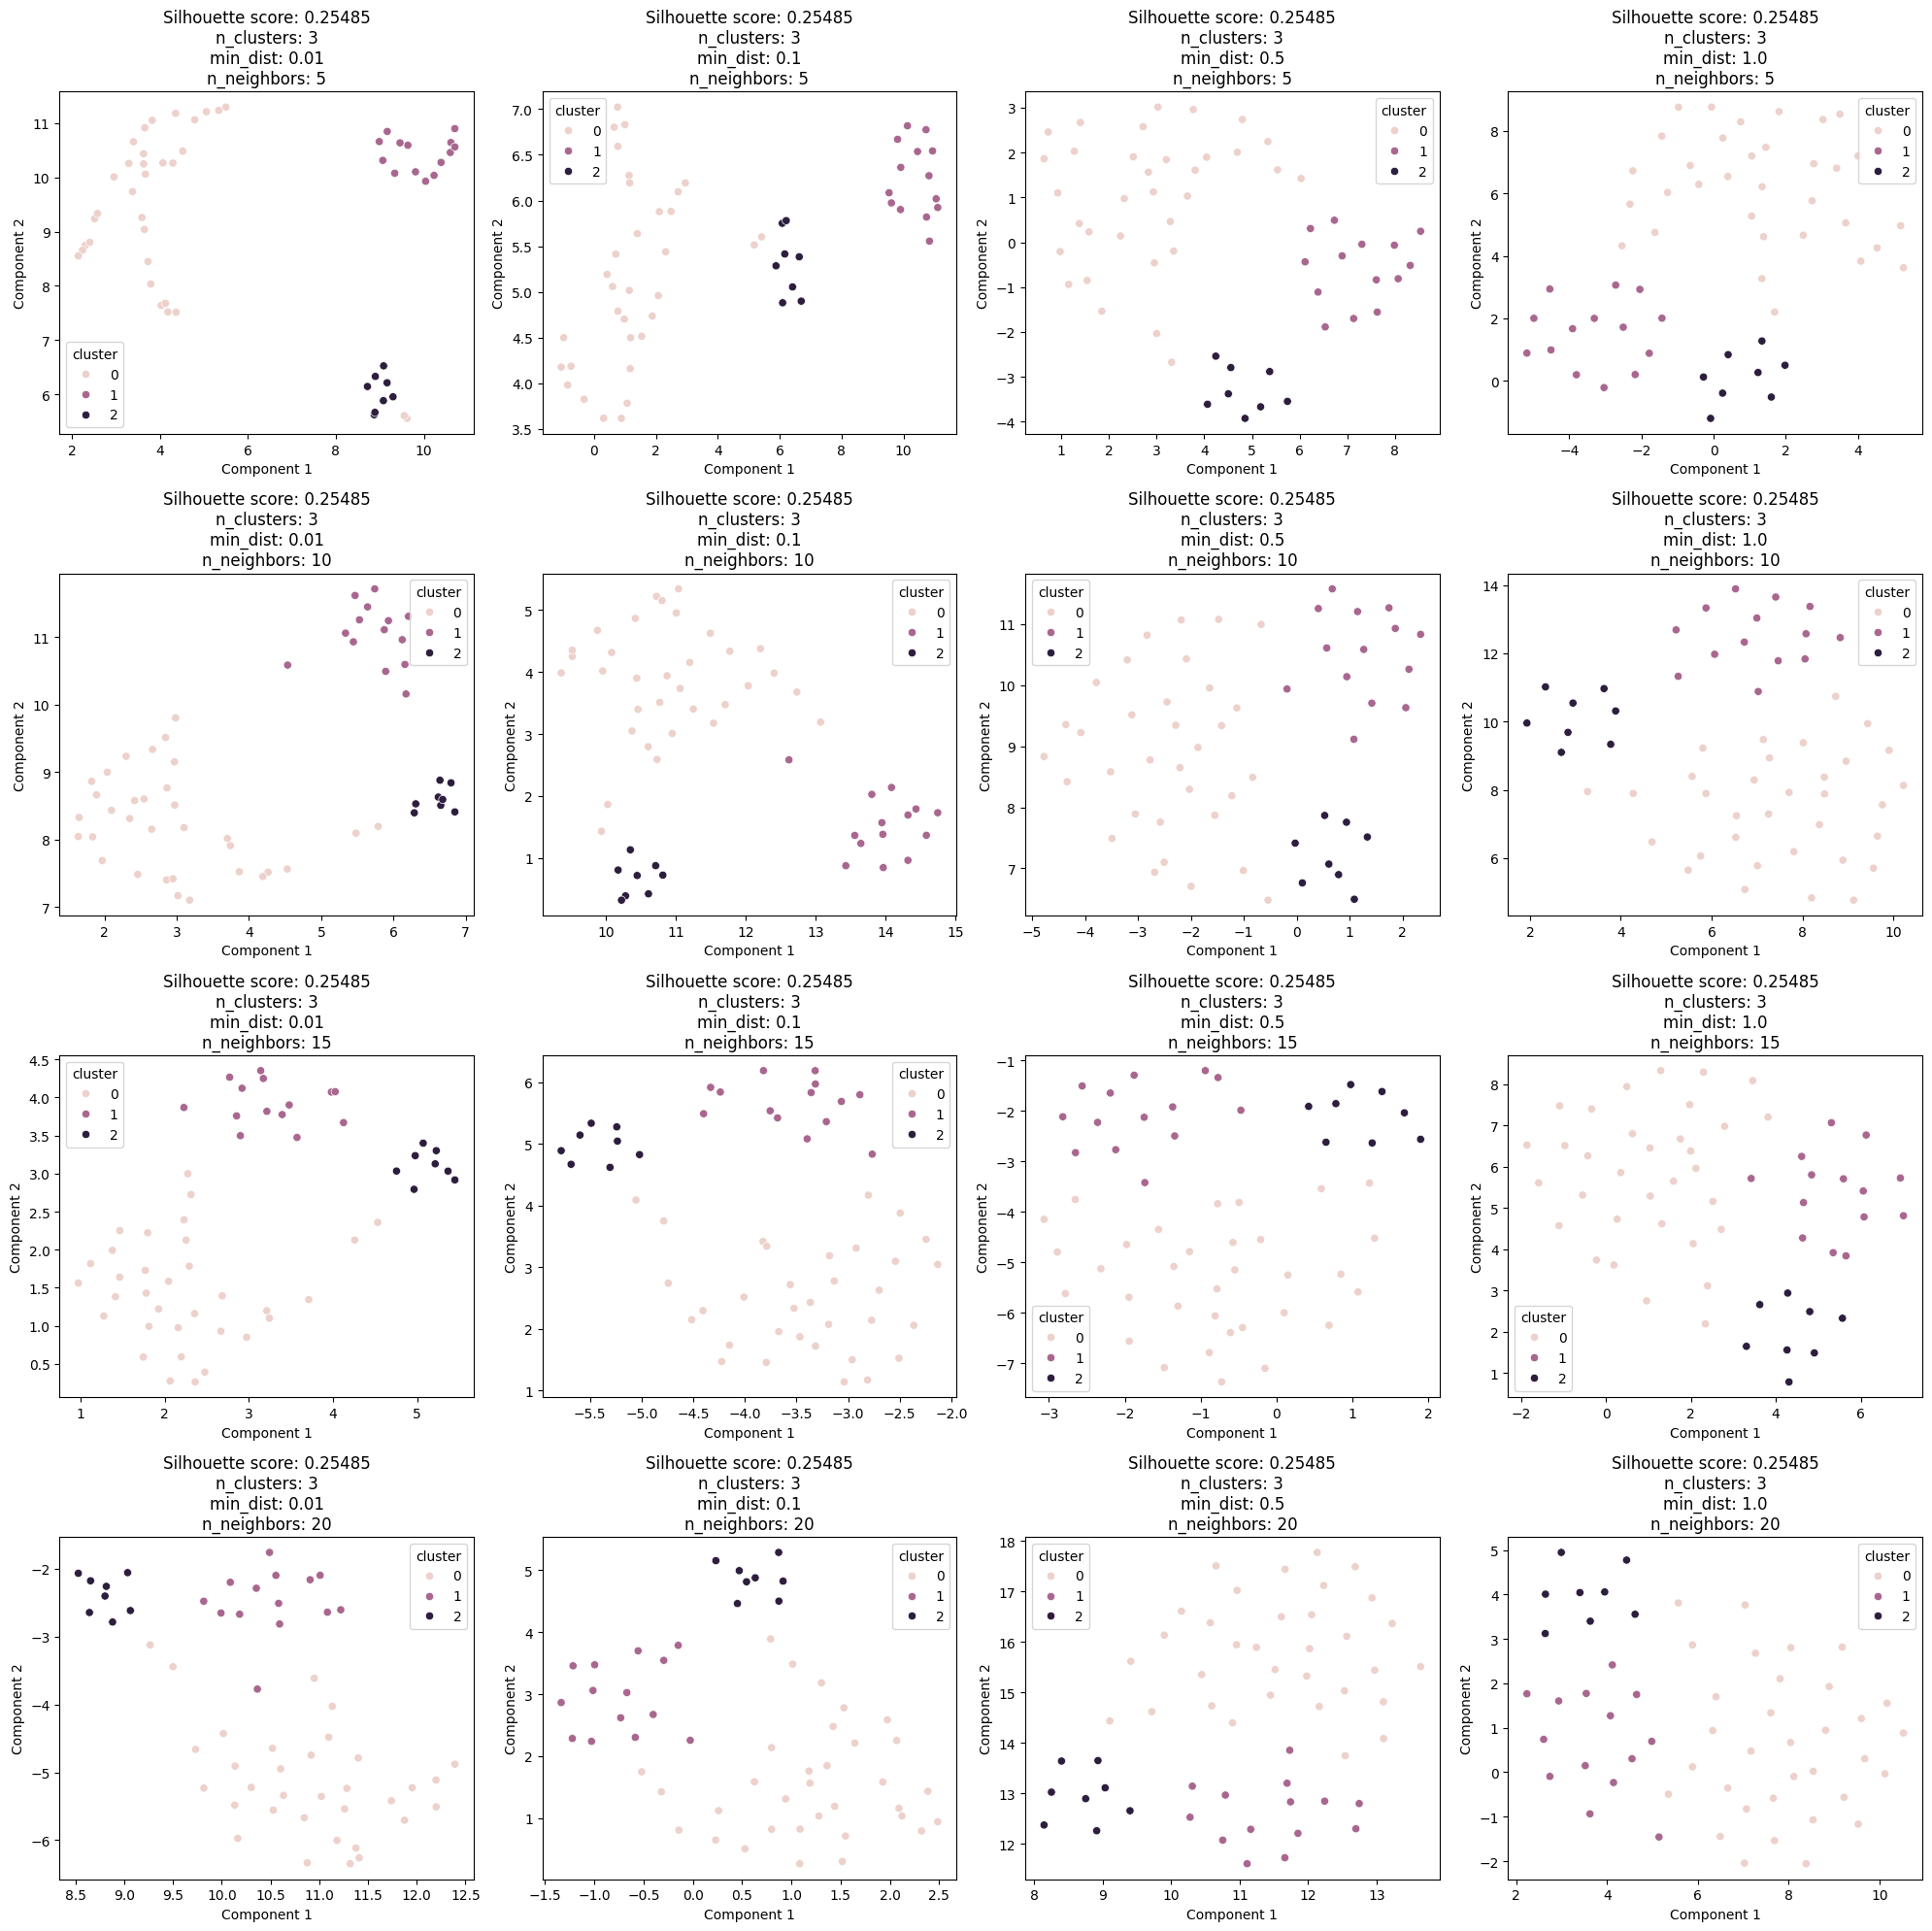

In [447]:
np.random.seed(42)

def plot_scatter_of_clusters(X, clustering_model = None, reducer=None, labels=None , arrows:bool=True, ax=None, title_print: dict = None):
    coeff = None
    n_features_provided = X.shape[1]
    if reducer is not None and n_features_provided > 2:
        X_reduced = reducer.fit_transform(X)
        if "PCA" in reducer.__str__():
            coeff = reducer.components_
        X_reduced_df = pd.DataFrame({"Component 1": X_reduced[:,0]
                                ,'Component 2': X_reduced[:,1]})
    else:
        if n_features_provided != 2:
            raise ValueError('Dimensionality reduction method must be provided when number of features are not 2')
        X_reduced_df = X

    x_var_name, y_var_name = X_reduced_df.columns

    if clustering_model is not None:
        try: 
            clustering_labels = clustering_model.labels_
        except:
            clustering_labels = clustering_model.predict(X)
            
        X_reduced_df["cluster"] = clustering_labels

        sns.scatterplot(X_reduced_df, x=x_var_name, y=y_var_name, hue='cluster', ax=ax)
        ax.set_title(f"Silhouette score: {round(silhouette_score(X, clustering_labels),5)}\nn_clusters: {len(np.unique(clustering_labels))}\nmin_dist: {title_print["min_dist"]}\nn_neighbors: {title_print["n_neighbors"]}")
        
    else:
        sns.scatterplot(X_reduced_df, x=x_var_name, y=y_var_name,ax=ax)
    
    if coeff is not None and arrows:
        n = coeff.shape[1]
        for i in range(n):
            plt.arrow(0, 0, coeff[0,i]*5, coeff[1,i]*5,color = 'r',alpha = 0.5)
            if labels is None:
                plt.text(coeff[0,i]* 5, coeff[1,i] * 5, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
            else:
                print(labels[i])
                plt.text(coeff[0,i]* 5, coeff[1,i] * 5, labels[i], color = 'g', ha = 'center', va = 'center')
  
selected_features_to_plot = list(selected_features_results["selected_features"][0].sort_values("Importance", ascending=False)["index"].unique())



model = AgglomerativeClustering(n_clusters=selected_features_results["n_clusters"][0], metric=metric, linkage=linkage)
model.fit(X[selected_features_to_plot])

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(20,20))

axs = np.array(ax).reshape(-1)


n_neighbors = np.repeat([5, 10, 15, 20],4)
min_dist = np.tile(np.array([0.01, 0.1, 0.5, 1]), 4)

for i in range(16):
    plot_scatter_of_clusters(X[selected_features_to_plot],
                            clustering_model=model,
                            reducer=umap.UMAP(n_neighbors=n_neighbors[i],
                                            min_dist=min_dist[i],
                                            random_state=42),
                            ax=axs[i],
                            title_print={'n_neighbors': n_neighbors[i],
                                         'min_dist': min_dist[i]})
plt.tight_layout()


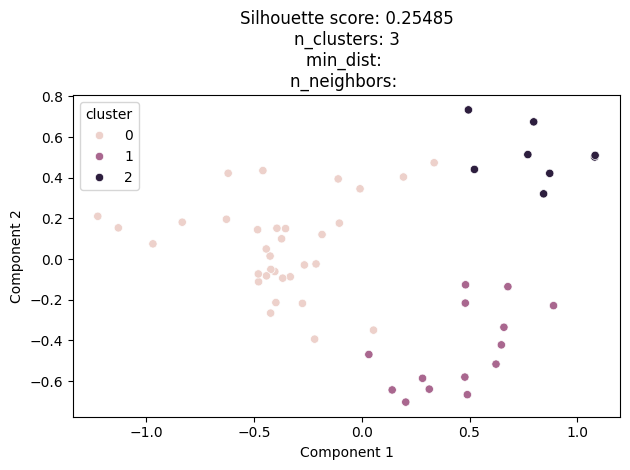

In [442]:
fig, ax = plt.subplots()
plot_scatter_of_clusters(X[selected_features_to_plot],
                            clustering_model=model,
                            reducer=PCA(),
                            ax=ax,
                            arrows=False,
                            title_print={'n_neighbors': '',
                                         'min_dist': ''})
plt.tight_layout()